In [1]:
#loading libraries
import platform; 
import sys;
import itertools
from collections import Counter
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import scipy.ndimage
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

from skimage import measure, morphology
%matplotlib inline
#loading libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn as sl
import matplotlib
import os
import scipy.ndimage
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

from skimage import measure, morphology


from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.ensemble import RUSBoostClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.combine import SMOTEENN
from imblearn.metrics import geometric_mean_score 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold

from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.ensemble import RUSBoostClassifier
from imblearn.metrics import geometric_mean_score
from catboost import CatBoostClassifier

import xgboost as xgb
import lightgbm as lgb

#fix random seed for reproducibility
RANDOM_STATE_VALUE = 1234

print("Python", sys.version)
print("NumPy", np.__version__)
print("SciPy", scipy.__version__)
print("Scikit-Learn", sl.__version__)
print("Matplotlib",matplotlib.__version__)

Python 3.5.2 (default, Nov 12 2018, 13:43:14) 
[GCC 5.4.0 20160609]
NumPy 1.16.4
SciPy 1.3.0
Scikit-Learn 0.20.3
Matplotlib 2.0.0


In [2]:
#data pre-processing
INPUT_FOLDER = 'rennes_prostate_cancer/input_data/'
OUTPUT_FOLDER = 'rennes_prostate_cancer/output_results/'
data_main = pd.read_excel(INPUT_FOLDER+'data.xls', index_col=None)

conditions = [
    (data_main['months'] < 36) & (data_main['bleeded']== 1.00)]
choices = [1.00]

data_main['36months'] = np.select(conditions, choices, default=0.00)

#data_main.to_csv(OUTPUT_FOLDER+'prepared_dataset.csv', encoding='utf-8', index=False) un comment if you want something else

train_data = data_main[data_main.cohort== 1]
test_data= data_main[data_main.cohort== 2]
print('Train Data: ' ,len(train_data))
print('Test Data: ' ,len(test_data))

from sklearn.utils import shuffle
train_data = shuffle(train_data)
test_data = shuffle(test_data)

#preparing training set
train_X = train_data.iloc[:,0:90].astype(float)
#train_temp_y = train_X.iloc[:,2].astype(float)
#target_train_X = train_data['36months']
#print('Labels of Trained data: ',len(train_temp_y))
#del train_X['36months']
del train_X['cohort']
del train_X['months']
del train_X['bleeded']
train_X.head()
#train_X.to_csv(OUTPUT_FOLDER+'prepared_dataset_test.csv', encoding='utf-8', index=False) #un comment if you want something else

#preparing testing set
test_X = test_data.iloc[:,0:90].astype(float)
test_temp_y = test_X.iloc[:,2].astype(float)
#target_test_X = test_data['36months']
#print('Labels of Test data: ' , len(test_temp_y))
#del test_X['36months']
del test_X['cohort']
del test_X['months']
del test_X['bleeded']
test_X.head()

target_train = train_X['36months']
target_test = test_X['36months']

train_set_labels = train_X.pop('36months')
test_set_labels = test_X.pop('36months')

Train Data:  337
Test Data:  254


In [5]:
from imblearn.under_sampling import TomekLinks
#plot values generated by SMOTE
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()
    
def convert_to_encoding(target_y):
    data_encoder = LabelEncoder()
    data_encoder.fit(target_y)
    encoded_y = data_encoder.transform(target_y)
    return encoded_y

def do_sampling_smote(train_X,target_Y,sampling_strategy = 'not minority',smoteenn=True):
    if smoteenn:
        smot_sampler = SMOTEENN(random_state=RANDOM_STATE_VALUE)
        X_res, Y_res = smot_sampler.fit_resample(train_X, convert_to_encoding(target_Y))
    else:
        #no_value=True
        smot_sampler= SMOTE(random_state=RANDOM_STATE_VALUE)
        #smot_sampler= BorderlineSMOTE(sampling_strategy=sampling_strategy,random_state=RANDOM_STATE_VALUE)
        #smot_sampler = RandomOverSampler(random_state=RANDOM_STATE_VALUE)
        X_res, Y_res = smot_sampler.fit_resample(train_X, convert_to_encoding(target_Y))
    return X_res,Y_res


def do_sampling_tomelinks(train_X,target_Y,ratio):
    tl = TomekLinks(return_indices=True, ratio=ratio)
    X_tl, y_tl, id_tl = tl.fit_sample(train_X, target_Y)
    return X_tl,y_tl,id_tl
    
def set_ggplot_style():
    plt.style.use('ggplot')
    
def list_of_styles():
    print(plt.style.available)

    
def view_tabular_feature_importances():
    pass

def set_plot_size(width,height):
    plt.rcParams['figure.figsize'] = [width,height]
    
def do_lgb_on_sampled_data(train_X,train_Y,regression=True):
    if regression:
        gbm = lgb.LGBMRegressor()
    else:
        #gbm = lgb.LGBMClassifier(class_weight='balanced')
        #gbm = lgb.LGBMClassifier(scale_pos_weight=1.5)
        gbm = lgb.LGBMClassifier()
    return gbm.fit(train_X, train_Y)

def do_xgb_on_sampled_data(train_X,train_Y,regression=True):
    if regression :
        print("TO DO")
    else:
        xgb_tuned = xgb.XGBClassifier(max_depth=20, n_estimators=200,min_child_weight= 1, learning_rate=0.2,subsample=0.6,
colsample_bytree=0.8,gamma=1,eval_metric='logloss',scale_pos_weight=1.8)
    return xgb_tuned.fit(train_X, train_Y)

def do_random_forest():
    rf_grid_searched_dose = RandomForestClassifier(bootstrap= True,criterion='entropy',max_depth=20,max_features='auto',min_samples_leaf=5,min_samples_split=8,n_estimators=300,random_state=RANDOM_STATE_VALUE)
    rf_vanila_dose = RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE_VALUE, n_jobs=-1)
    return rf_vanila_dose

def do_catboost_on_sampled_data(train_X,train_Y,regression=True):
    if regression:
        print("TO DO ")
    else :
        #model_cat = CatBoostClassifier(eval_metric='BalancedAccuracy',use_best_model=True,random_seed=1234)
        model_cat = CatBoostClassifier(eval_metric='BalancedAccuracy',random_seed=1234)
    return model_cat.fit(train_X, train_Y)   
        
def create_confusion_matrix(predictions,target_y):
    encoded_y = convert_to_encoding(target_y) 
    cm = confusion_matrix(encoded_y, predictions)
    return cm,encoded_y
    
def predict_and_create_cm(model,target_x,target_y):
    encoded_y = convert_to_encoding(target_y) 
    predictions = model.predict(target_x)
    cm = confusion_matrix(encoded_y, predictions)
    return cm,predictions,encoded_y


#calculcate sensitivity and specificity
def calculate_custom_sensitivity(cm):
    tp = cm[1,1]
    tn = cm[0,0]
    fp= cm[0,1]
    fn=cm[1,0]
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = tp/(tp+fn)
    # Specificity or true negative rate
    TNR = tn/(tn+fp)
    return TPR,TNR

#calculate 
def plot_confusion_matrix_with_report(cm, classes,ax,bc,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    print('')
    
    #calculate sensitivity and specificity
    sensitivity,specificity= calculate_custom_sensitivity(cm)
 
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.sca(ax)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label\n bac={:0.2f};sen={:0.2f}:spe={:0.2f}'.format(bc,round(sensitivity,2),round(specificity,2))) 
    ax.grid(False)



def apply_heuristics_on_generate_data(generated_data_x,generated_data_y,columns_list,train_dummy_X,test_dummy_X,target_train,target_test):
    data_frame_generated = pd.DataFrame(generated_data_x,columns=columns_list)
    data_frame_generated['36months'] = generated_data_y
    
    train_dummy_X['36months'] = target_train
    test_dummy_X['36months'] = target_test
    
    merged_dataframe_test = pd.concat([data_frame_generated, test_dummy_X]) 
    merged_dataframe_test.drop_duplicates(keep=False, inplace=True)
  
    
    merged_dataframe_train = pd.concat([train_dummy_X, merged_dataframe_test]) 
    
    return data_frame_generated,merged_dataframe_test,merged_dataframe_train
 
def get_single_count_from_data_frame (df,variable_name):
    no_,yes_ = df[variable_name].value_counts()
    return no_,yes_

def apply_pseudo_labeling(model,target_X,proba_score,train_X,train_Y):
    predictions_in_probability = predict_proba_model(model,target_X)
    predictions_in_probability_modified = (predictions_in_probability [:,1] >= proba_score).astype('int')
    prediction_dataframe = pd.DataFrame(predictions_in_probability_modified,columns=['36months'])
    augmented_test = target_X.copy(deep=True)
    augmented_test['36months'] = predictions_in_probability_modified
    
    
    augmented_test_label= augmented_test['36months']
    augmented_set_labels = augmented_test.pop('36months')
    new_train_X = np.vstack((train_X, augmented_test.values))
    new_train_Y = np.concatenate((train_Y, augmented_test_label.values), axis=0)
    
    return prediction_dataframe,augmented_test,new_train_X,new_train_Y

def create_merged_data_frame(model,target_X,proba_score,generated_data_x,generated_data_y,columns_list,is_xgb):
    if is_xgb:
        test_X_matrix = target_X.as_matrix()
        predictions_in_probability = predict_proba_model(model,test_X_matrix)
    else :
        predictions_in_probability = predict_proba_model(model,target_X)
        
    predictions_in_probability_modified = (predictions_in_probability [:,1] >= proba_score).astype('int')
    prediction_dataframe = pd.DataFrame(predictions_in_probability_modified,columns=['36months'])
    augmented_test = target_X.copy(deep=True)
    augmented_test['36months'] = predictions_in_probability_modified
    
    data_frame_generated = pd.DataFrame(generated_data_x,columns=columns_list)
    data_frame_generated['36months'] = generated_data_y
    
    merged_dataframe_train = pd.concat([data_frame_generated, augmented_test])
    
    return merged_dataframe_train    
    
    
def predict_proba_model(model,target_X):
    predictions_probability = model.predict_proba(target_X)
    return predictions_probability

def pop_labels(dataframe,label_name):
    dataframe_label = dataframe[label_name]
    dataframe.pop(label_name)
    return dataframe,dataframe_label

def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)


def merge_dataframe_only(list_of_dfs):
    merged =pd.concat([merged_df_rf,merged_df_xgb,merged_df_lgb,merged_df_cat]) 
    merged.drop_duplicates(keep='first', inplace=True)
    merged = clean_dataset(merged)
    return shuffle(merged)

def find_best_cut_off(true_Y,predicted_y):
    fpr, tpr, thresholds = roc_curve(true_Y,predicted_y[:,1],pos_label=1)
    optimal_idx=np.argmin(np.sqrt(np.square(1-tpr) + np.square(fpr)))
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold

def draw_roc_curve(Y,probs,title):
    # Perforamnce of the model
    fpr, tpr, thresholds = roc_curve(Y,probs,pos_label=1)
    #print('tpr: ', tpr)
    roc_score = roc_auc_score (Y,probs)
    AUC  = auc(fpr, tpr)
    print ('The AUC is : %0.4f' %  AUC)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % AUC)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for %s' %title)
    plt.legend(loc="lower right")
    plt.show()

def prepare_data_set_cox_analysis_and_classification(data_main):
    train_data_temp = data_main[data_main.cohort== 1]
    test_data_temp= data_main[data_main.cohort== 2]
    
    print('Procesing Train Data for cox analysis and classification :' ,len(train_data_temp))
    print('Procesing Test Data: for cox analysis and classification :' ,len(test_data_temp))

    train_data_temp = shuffle(train_data_temp)
    test_data_temp = shuffle(test_data_temp)

    test_data_temp['36months']= test_data_temp['36months'].astype('bool')

    train_X_temp = train_data_temp.iloc[:,0:90].astype(float)
    train_temp_y = train_data_temp.iloc[:,2].astype(float)
    
    del train_X_temp['36months']
    del train_X_temp['cohort']
    del train_X_temp['bleeded']

    test_X_temp = test_data_temp.iloc[:,0:90].astype(float)
    test_temp_y = test_data_temp.iloc[:,[0,2]]
    
    del test_X_temp['36months']
    del test_X_temp['months']
    del test_X_temp['cohort']
    del test_X_temp['bleeded']
    
    return train_X_temp,train_temp_y,test_X_temp,test_temp_y


def create_data_set_for_cox_and_classification_after_smote (X_res_train_temp,Y_res_train_temp,columns_list):
    data_frame_generated = pd.DataFrame(X_res_train_temp,columns=columns_list)
    data_frame_generated['36months'] = Y_res_train_temp
    data_frame_cox_target = data_frame_generated.iloc[:,[0,87]]
    #del data_frame_generated['months']
    return data_frame_generated,data_frame_cox_target


def plot_feature_importances(model,feature_names,number_of_features,title):
    plt.rcParams['figure.figsize'] = [10,8]
    feat_importances = pd.Series(model.feature_importances_, index=feature_names.columns)
    feat_importances.nlargest(20).plot(kind='barh',color=colors)
    plt.title('First {} Important Features for {}'.format(number_of_features, title) , fontsize = 20)
    plt.yticks(fontsize = 10)
    plt.ylabel('Name of the features',fontsize = 20)
    
    
#helper function to generate color palette
import random

def get_random_color(pastel_factor = 0.7):
    return [(x+pastel_factor)/(1.0+pastel_factor) for x in [random.uniform(0,1.0) for i in [1,2,3]]]

def color_distance(c1,c2):
    return sum([abs(x[0]-x[1]) for x in zip(c1,c2)])

def generate_new_color(existing_colors,pastel_factor = 0.5):
    max_distance = None
    best_color = None
    for i in range(0,100):
        color = get_random_color(pastel_factor = pastel_factor)
        if not existing_colors:
            return color
        best_distance = min([color_distance(color,c) for c in existing_colors])
        if not max_distance or best_distance > max_distance:
            max_distance = best_distance
            best_color = color
    return best_color

colors = []
for i in range(0,30):
    colors.append(generate_new_color(colors,pastel_factor = 0.8))
    
def get_important_features_list (model,columns_list,num_of_features):
    feat_importances = pd.Series(model.feature_importances_, index=columns_list)
    df=feat_importances.nlargest(num_of_features)
    important_features_list = []
    
    for i, v in df.items():
        important_features_list.append(i)
    return important_features_list

    

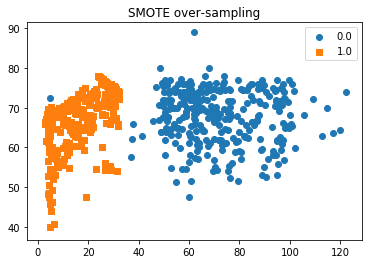

Resampled dataset shape for training set:  Counter({0.0: 310, 1.0: 310})


In [44]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(ratio='minority')
X_res_train_temp,Y_res_train_temp = smote.fit_sample(train_prep_X, train_prep_y)

plot_2d_space(X_res_train_temp,Y_res_train_temp, 'SMOTE over-sampling')
print('Resampled dataset shape for training set:  %s' % Counter(Y_res_train_temp))

Resampled dataset shape for training set TOME:  Counter({1: 310, 0: 299})


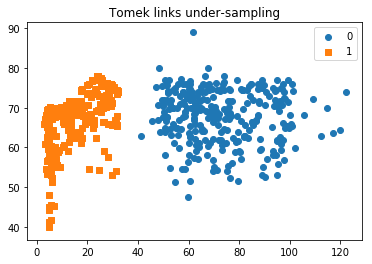

In [97]:
X_res_train_temp,Y_res_train_temp,idx = do_sampling_tomelinks(X_res_train_temp_s,Y_res_train_temp_s,'majority')
print('Resampled dataset shape for training set TOME:  %s' % Counter(Y_res_train_temp))
plot_2d_space(X_res_train_temp, Y_res_train_temp, 'Tomek links under-sampling')

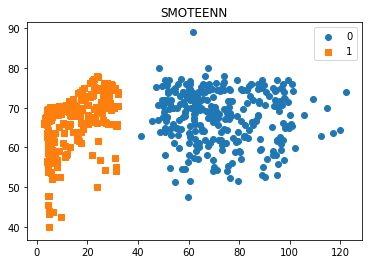

In [90]:
plot_2d_space(X_res_train_temp, Y_res_train_temp, 'SMOTEENN')

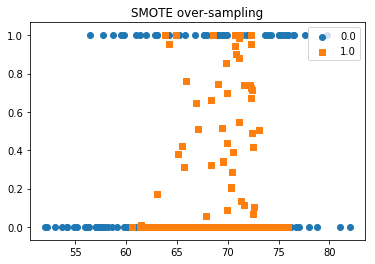

Resampled dataset shape for training set:  Counter({0.0: 232, 1.0: 232})


In [113]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(ratio='minority')
X_res_test_temp,Y_res_test_temp  = smote.fit_sample(test_X,target_test)

plot_2d_space(X_res_test_temp,Y_res_test_temp, 'SMOTE over-sampling')
print('Resampled dataset shape for training set:  %s' % Counter(Y_res_test_temp))

Resampled dataset shape for training set:  Counter({1: 211, 0: 125})


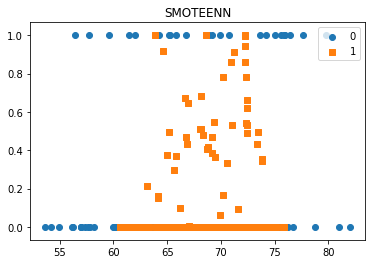

In [111]:
X_res_test_temp,Y_res_test_temp = do_sampling_smote(test_X,target_test,sampling_strategy = 'not minority',smoteenn=True)
print('Resampled dataset shape for training set:  %s' % Counter(Y_res_test_temp))
plot_2d_space(X_res_test_temp, Y_res_test_temp, 'SMOTEENN')


Resampled dataset shape for training set:  Counter({0.0: 221, 1.0: 22})


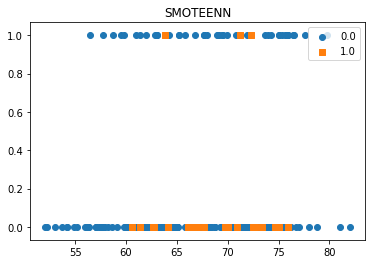

In [112]:
X_res_test_temp,Y_res_test_temp,t = do_sampling_tomelinks(test_X,target_test,'majority')
print('Resampled dataset shape for training set:  %s' % Counter(Y_res_test_temp))
plot_2d_space(X_res_test_temp, Y_res_test_temp, 'SMOTEENN')

In [98]:
train_prep_X,train_prep_y,test_cox_X,test_cox_y = prepare_data_set_cox_analysis_and_classification(data_main)
train_prep_X.head(2)
#X_res_train_temp,Y_res_train_temp,idx = do_sampling_tomelinks(train_prep_X,train_prep_y,'majority')
X_res_train_temp,Y_res_train_temp = do_sampling_smote(train_prep_X,train_prep_y,sampling_strategy = 'not minority',smoteenn=True)
print('Resampled dataset shape for training set:  %s' % Counter(Y_res_train_temp_s))

#print('Resampled dataset shape for training set TOME:  %s' % Counter(Y_res_train_temp))
#plot_2d_space(X_res_train_temp, Y_res_train_temp, 'Tomek links under-sampling')

print('Preparing Training set after applying SMOTEENN')
data_frame_train_X,data_frame_cox_target = create_data_set_for_cox_and_classification_after_smote(X_res_train_temp,Y_res_train_temp,train_prep_X.columns)
data_frame_target_train = data_frame_train_X['36months']
data_frame_train_set_labels = data_frame_train_X.pop('36months')

del data_frame_train_X['months']

data_frame_train_X.head(2)

Procesing Train Data for cox analysis and classification : 337
Procesing Test Data: for cox analysis and classification : 254
Resampled dataset shape for training set:  Counter({1: 310, 0: 299})
Preparing Training set after applying SMOTEENN


,age,antticoagulant_i,hormono,dose_total in the prostate,"imrt_only (0=no, 1=yes)",imr_plus_igrt,V0,V1= Volume of the rectum in % receiving a minimum of 1 Gy,V2,V3,...,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79
0,71.624658,0.0,1.0,80.0,1.0,0.0,100.0,100.0,95.8754,93.2547,...,6.08019,5.22345,4.36347,3.41694,2.25538,0.871584,0.046544,0.0,0.0,0.0
1,74.356164,0.0,1.0,80.0,1.0,0.0,100.0,100.0,100.0000,99.4973,...,22.08200,19.88620,16.79870,13.41200,7.10466,0.556925,0.002048,0.0,0.0,0.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


Balanced Accuracy for RF:  46.0
MCC for RF:  -0.0900273397253598
ROC :  46.0
Confusion Matrix: 
Sensitivity: 0.00: and Specificity:0.91

The AUC is : 0.4569


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.


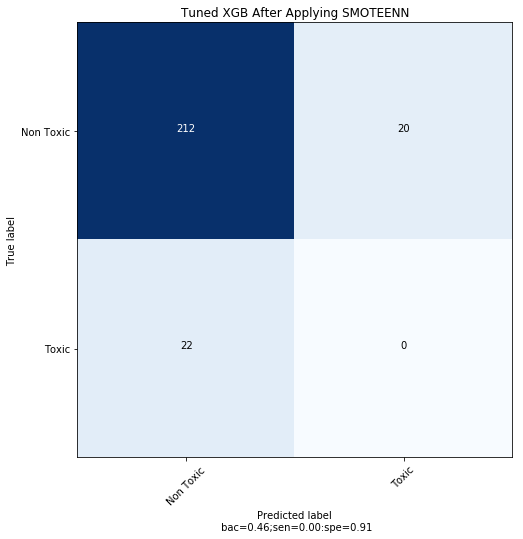

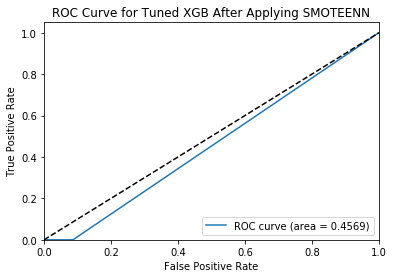

ROC :  0.4568965517241379


In [92]:
test_X_matrix = test_X.as_matrix()
xgb_model_clf_train = xgb.XGBClassifier(max_depth=20, n_estimators=200,min_child_weight= 1, learning_rate=0.2,subsample=0.6,
colsample_bytree=0.8,gamma=1,eval_metric='auc')

#xgb.XGBClassifier(max_depth=20, n_estimators=500,eval_metric='auc')

xgb_model_clf_train.fit(data_frame_train_X.as_matrix(), data_frame_target_train)


cm,predictions,test_Y = predict_and_create_cm(xgb_model_clf_train,test_X.as_matrix(),target_test)




balanced_accuracy = recall_score(test_Y,predictions, average='macro') 
mcc_coef= matthews_corrcoef(test_Y, predictions)
roc_score = roc_auc_score (test_Y,predictions)

print('Balanced Accuracy for RF: ' , round(balanced_accuracy,2)*100)
print('MCC for RF: ' , mcc_coef)
print('ROC : ' , round(roc_score,2)*100)
print('Confusion Matrix: ')
sensititvity,specificity = calculate_custom_sensitivity(cm)
print("Sensitivity: {:0.2f}: and Specificity:{:0.2f}".format(sensititvity,specificity))

fig, ax = plt.subplots(ncols=1,figsize=(8,8))
plot_confusion_matrix_with_report(cm, classes=['Non Toxic', 'Toxic'],ax=ax,bc=balanced_accuracy,
                      title='Tuned XGB After Applying SMOTEENN')

draw_roc_curve(test_Y,predictions,'Tuned XGB After Applying SMOTEENN')
roc_score = roc_auc_score (test_Y,predictions)
print('ROC : ' , roc_score)

Balanced Accuracy for RF:  48.0
MCC for RF:  -0.03290789585457231
ROC :  48.0
Confusion Matrix: 
Sensitivity: 0.14: and Specificity:0.82

The AUC is : 0.4777


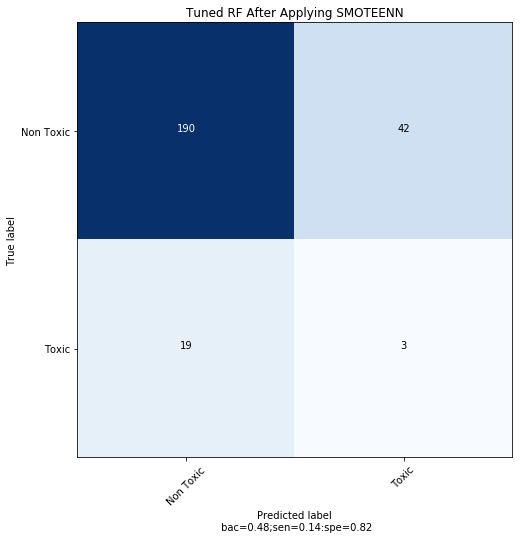

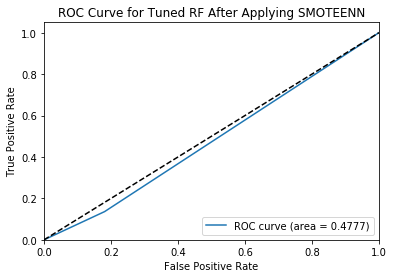

ROC :  0.47766457680250785


In [101]:
rf_ = RandomForestClassifier(bootstrap= True,criterion='entropy',max_depth=20,max_features='auto',min_samples_leaf=5,min_samples_split=8,n_estimators=500,random_state=RANDOM_STATE_VALUE)
#rf_ = RandomForestClassifier(n_estimators=500,max_depth=20,random_state=RANDOM_STATE_VALUE)
#rf_.fit(X_res_train, Y_res_train)
rf_.fit(data_frame_train_X, data_frame_target_train)

cm,predictions,test_Y = predict_and_create_cm(rf_,test_X,target_test)

balanced_accuracy = recall_score(test_Y,predictions, average='macro') 
mcc_coef= matthews_corrcoef(test_Y, predictions)
roc_score = roc_auc_score (test_Y,predictions)

print('Balanced Accuracy for RF: ' , round(balanced_accuracy,2)*100)
print('MCC for RF: ' , mcc_coef)
print('ROC : ' , round(roc_score,2)*100)
print('Confusion Matrix: ')
sensititvity,specificity = calculate_custom_sensitivity(cm)
print("Sensitivity: {:0.2f}: and Specificity:{:0.2f}".format(sensititvity,specificity))

fig, ax = plt.subplots(ncols=1,figsize=(8,8))
plot_confusion_matrix_with_report(cm, classes=['Non Toxic', 'Toxic'],ax=ax,bc=balanced_accuracy,
                      title='Tuned RF After Applying SMOTEENN')

draw_roc_curve(test_Y,predictions,'Tuned RF After Applying SMOTEENN')
roc_score = roc_auc_score (test_Y,predictions)
print('ROC : ' , roc_score)

Optimal cut-off value: 0.26
Balanced Accuracy for RF:  66.0
MCC for RF:  0.13252438894192922
ROC :  62.0
Confusion Matrix: 
Sensitivity: 0.77: and Specificity:0.46

The AUC is : 0.6170


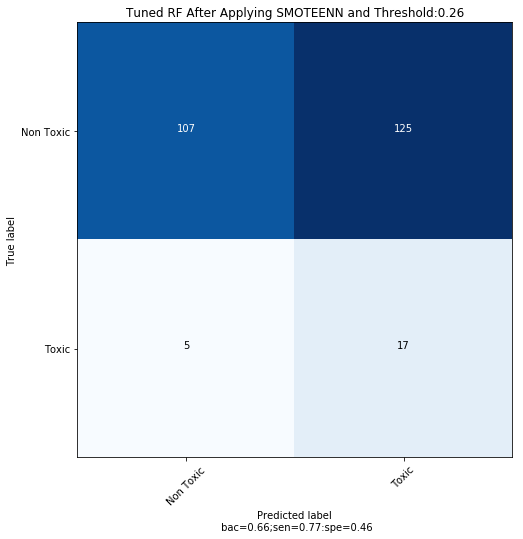

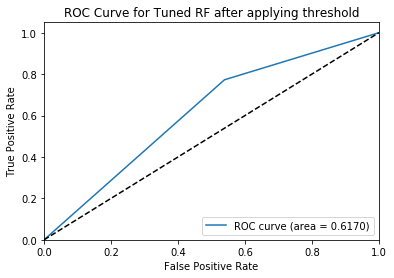

In [102]:
test_Y = convert_to_encoding(target_test) 
probs_rf_grid_searched_dose_thres = predict_proba_model(rf_,test_X)
threshold = round(find_best_cut_off(test_Y,probs_rf_grid_searched_dose_thres),2)
print('Optimal cut-off value:' , threshold)
#threshold = find_best_cut_off(test_Y,predictions)


probs_rf_grid_searched_dose_thres = predict_proba_model(rf_,test_X)
predicted_grid_searched_dose_thres = (probs_rf_grid_searched_dose_thres [:,1] >= threshold).astype('int')



cm = confusion_matrix(test_Y, predicted_grid_searched_dose_thres)

balanced_accuracy = recall_score(test_Y,predicted_grid_searched_dose_thres, average='macro') 
mcc_coef= matthews_corrcoef(test_Y, predicted_grid_searched_dose_thres)
roc_score = roc_auc_score (test_Y,predicted_grid_searched_dose_thres)

print('Balanced Accuracy for RF: ' , round(balanced_accuracy,2)*100)
print('MCC for RF: ' , mcc_coef)
print('ROC : ' , round(roc_score,2)*100)
print('Confusion Matrix: ')
sensititvity,specificity = calculate_custom_sensitivity(cm)
print("Sensitivity: {:0.2f}: and Specificity:{:0.2f}".format(sensititvity,specificity))

fig, ax = plt.subplots(ncols=1,figsize=(8,8))
plot_confusion_matrix_with_report(cm, classes=['Non Toxic', 'Toxic'],ax=ax,bc=balanced_accuracy,
                      title='Tuned RF After Applying SMOTEENN and Threshold:'+str(threshold))



draw_roc_curve(test_Y,predicted_grid_searched_dose_thres,'Tuned RF after applying threshold')

In [103]:
merged_df_rf = create_merged_data_frame(rf_,test_X,0.5,data_frame_train_X,data_frame_target_train,data_frame_train_X.columns,False)
merged_df_rf = shuffle(merged_df_rf)
merged_df_rf.drop_duplicates(keep='first', inplace=True)
merged_df_rf.shape 

(863, 87)

In [104]:
#merged data frame 
list_of_dfs = [merged_df_rf]
#merged_df = merge_dataframe_only(list_of_dfs)

#merged_df = merged_df_mv
#print(merged_df.shape)

#no,yes = get_single_count_from_data_frame (merged_dataframe_three,'36months')
#print('No Toxicity: ',no)
#print('Toxicity: ',yes)

augmented_x,augmented_test_y = pop_labels(merged_df_rf,'36months')
#X_res_train_augmented,Y_res_train_augmented = do_sampling_smote(augmented_x,augmented_test_y,sampling_strategy = 'not minority',smoteenn=True)

#X_res_train_augmented,Y_res_train_augmented = do_sampling_smote(augmented_x,augmented_test_y,sampling_strategy = 'not minority',smoteenn=True)

#print(sorted(Counter(y_res).items()))




Resampled dataset shape for training set:  Counter({0: 493, 1: 355})


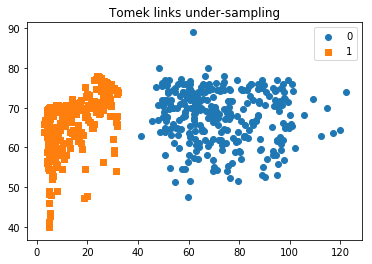

In [105]:
X_res_train_augmented_t,Y_res_train_augmented_t ,idx = do_sampling_tomelinks(augmented_x,augmented_test_y,'majority')
print('Resampled dataset shape for training set:  %s' % Counter(Y_res_train_augmented_t))
plot_2d_space(X_res_train_temp, Y_res_train_temp, 'Tomek links under-sampling')

Resampled dataset shape for training set:  Counter({1: 443, 0: 277})


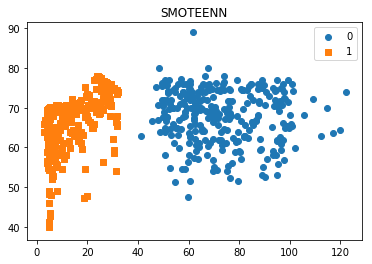

In [107]:
X_res_train_augmented,Y_res_train_augmented = do_sampling_smote(augmented_x,augmented_test_y,sampling_strategy = 'not minority',smoteenn=True)

print('Resampled dataset shape for training set:  %s' % Counter(Y_res_train_augmented_t1))
plot_2d_space(X_res_train_temp, Y_res_train_temp, 'SMOTEENN')

Resampled dataset shape for training set:  Counter({0.0: 544, 1.0: 35})


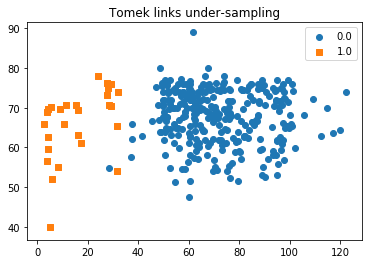

In [64]:
X_res_train_augmented,Y_res_train_augmented ,idx = do_sampling_tomelinks(augmented_x,augmented_test_y,'majority')
print('Resampled dataset shape for training set:  %s' % Counter(Y_res_train_augmented))
plot_2d_space(X_res_train_temp, Y_res_train_temp, 'Tomek links under-sampling')
print('Resampled dataset shape for training set:  %s' % Counter(Y_res_train_augmented))

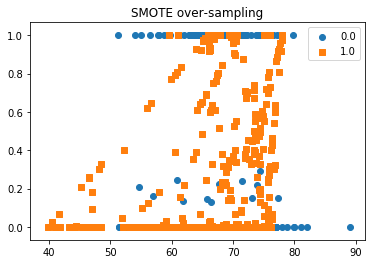

Resampled dataset shape for training set:  Counter({0.0: 544, 1.0: 544})


In [41]:
smote = SMOTE(ratio='minority')
X_res_train_augmented,Y_res_train_augmented = smote.fit_sample(augmented_x, augmented_test_y)

plot_2d_space(X_res_train_augmented,Y_res_train_augmented, 'SMOTE over-sampling')
print('Resampled dataset shape for training set:  %s' % Counter(Y_res_train_augmented))

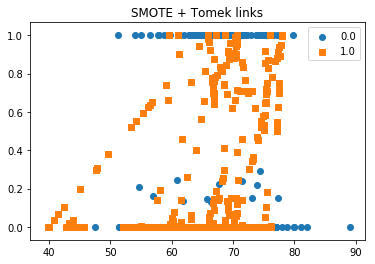

Resampled dataset shape for training set:  Counter({0.0: 546, 1.0: 546})


In [54]:
smt = SMOTETomek(ratio='auto')
X_res_train_augmented,Y_res_train_augmented  = smt.fit_sample(augmented_x, augmented_test_y)

plot_2d_space(X_res_train_augmented,Y_res_train_augmented, 'SMOTE + Tomek links')
print('Resampled dataset shape for training set:  %s' % Counter(Y_res_train_augmented))

Balanced Accuracy for RF:  49.0
MCC for RF:  -0.017481443071507986
ROC :  49.0
Confusion Matrix: 
[[184  48]
 [ 18   4]]
Sensitivity: 0.18: and Specificity:0.79

The AUC is : 0.4875


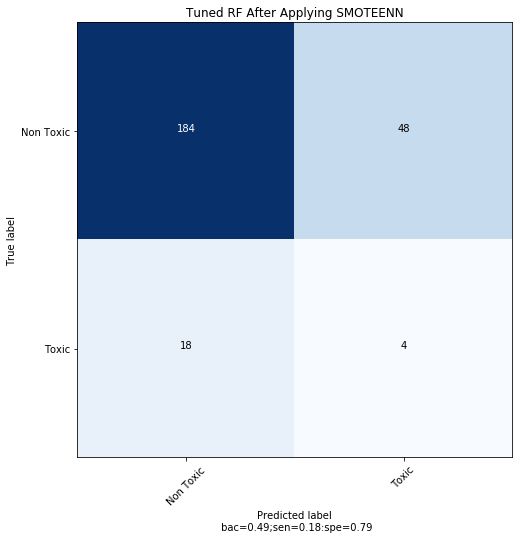

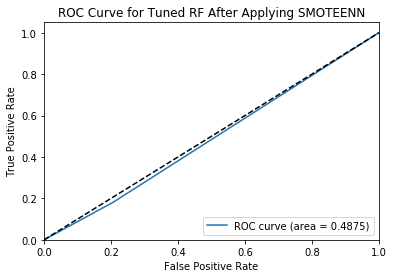

ROC :  0.487460815047022


In [114]:
rf_pseudo = RandomForestClassifier(bootstrap= True,criterion='entropy',max_depth=20,max_features='auto',min_samples_leaf=5,min_samples_split=8,n_estimators=300,random_state=RANDOM_STATE_VALUE)

#rf_pseudo = RandomForestClassifier(n_estimators=500,max_depth=20,random_state=RANDOM_STATE_VALUE)
#rf_pseudo.fit(augmented_x, augmented_test_y)
rf_pseudo.fit(X_res_train_augmented,Y_res_train_augmented)

cm,predictions,test_Y = predict_and_create_cm(rf_pseudo,test_X,target_test)

balanced_accuracy = recall_score(test_Y,predictions, average='macro') 
mcc_coef= matthews_corrcoef(test_Y, predictions)
roc_score = roc_auc_score (test_Y,predictions)

print('Balanced Accuracy for RF: ' , round(balanced_accuracy,2)*100)
print('MCC for RF: ' , mcc_coef)
print('ROC : ' , round(roc_score,2)*100)
print('Confusion Matrix: ')
print(cm)
sensititvity,specificity = calculate_custom_sensitivity(cm)
print("Sensitivity: {:0.2f}: and Specificity:{:0.2f}".format(sensititvity,specificity))

fig, ax = plt.subplots(ncols=1,figsize=(8,8))
plot_confusion_matrix_with_report(cm, classes=['Non Toxic', 'Toxic'],ax=ax,bc=balanced_accuracy,
                      title='Tuned RF After Applying SMOTEENN')

draw_roc_curve(test_Y,predictions,'Tuned RF After Applying SMOTEENN')
roc_score = roc_auc_score (test_Y,predictions)
print('ROC : ' , roc_score)

Optimal cut-off value: 0.19
Balanced Accuracy for RF:  62.0
MCC for RF:  0.13273597227693096
ROC :  62.0
Confusion Matrix: 
Sensitivity: 0.73: and Specificity:0.51

The AUC is : 0.6179


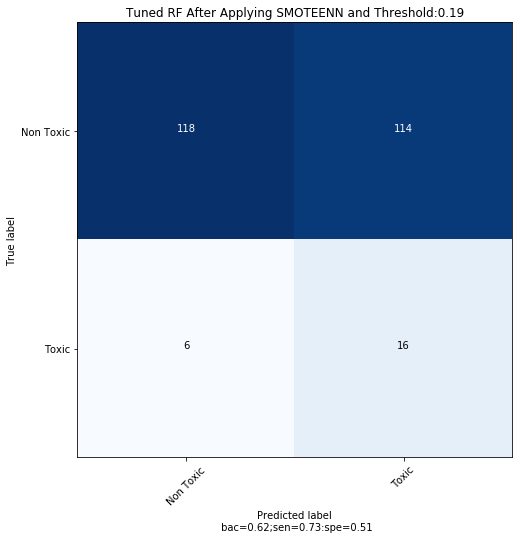

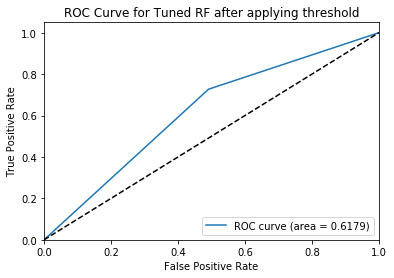

In [116]:
test_Y = convert_to_encoding(target_test) 
probs_rf_grid_searched_dose_thres = predict_proba_model(rf_pseudo,test_X)
threshold = round(find_best_cut_off(test_Y,probs_rf_grid_searched_dose_thres),2)
print('Optimal cut-off value:' , threshold)
#threshold = find_best_cut_off(test_Y,predictions)

predicted_grid_searched_dose_thres = (probs_rf_grid_searched_dose_thres [:,1] >= threshold).astype('int')


cm = confusion_matrix(test_Y, predicted_grid_searched_dose_thres)

balanced_accuracy = recall_score(test_Y,predicted_grid_searched_dose_thres, average='macro') 
mcc_coef= matthews_corrcoef(test_Y, predicted_grid_searched_dose_thres)
roc_score = roc_auc_score (test_Y,predicted_grid_searched_dose_thres)

print('Balanced Accuracy for RF: ' , round(balanced_accuracy,2)*100)
print('MCC for RF: ' , mcc_coef)
print('ROC : ' , round(roc_score,2)*100)
print('Confusion Matrix: ')
sensititvity,specificity = calculate_custom_sensitivity(cm)
print("Sensitivity: {:0.2f}: and Specificity:{:0.2f}".format(sensititvity,specificity))




fig, ax = plt.subplots(ncols=1,figsize=(8,8))
plot_confusion_matrix_with_report(cm, classes=['Non Toxic', 'Toxic'],ax=ax,bc=balanced_accuracy,
                      title='Tuned RF After Applying SMOTEENN and Threshold:'+str(threshold))


draw_roc_curve(test_Y,predicted_grid_searched_dose_thres,'Tuned RF after applying threshold')